In [1]:
model_dir = 'saved_model/2024-10-13_11-46-54-epoch-199.model'

In [2]:
import torch
from models.estimator import Estimator, UNet
from PIL import Image
from torchvision.transforms import v2, Compose, ToTensor, Normalize, Resize
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
import cv2
import math
import torchvision.transforms as T

In [3]:
# Control
import time

In [4]:
raw_path = "qqq.jpg"
img = cv2.imread(raw_path)  # make sure to use 'img', not 'img_raw'
height, width = img.shape[:2]

print(f"Height: {height}, Width: {width}")

Height: 8031, Width: 14277


In [5]:
# This function splits the image to dimSize x dimSize. It returns perfect shape so no padding needed.
def cutting(img,dimSize):
    # Modify the image by getting maxima
    height, width = img.shape[:2]

    # Resize image to next multiple of dimSize (Perfect division, no scaling)
    new_height = math.ceil(height / dimSize) * dimSize
    new_width = math.ceil(width / dimSize) * dimSize

    resized_img = cv2.resize(img, (new_width, new_height))

    tiles = []
    for y in range(0, new_height, dimSize):
        for x in range(0, new_width, dimSize):
            tile = resized_img[y:y+dimSize, x:x+dimSize]
            tiles.append(tile)

    return tiles, new_height, new_width


In [6]:
tiles, new_height,new_width = cutting(img, 512)

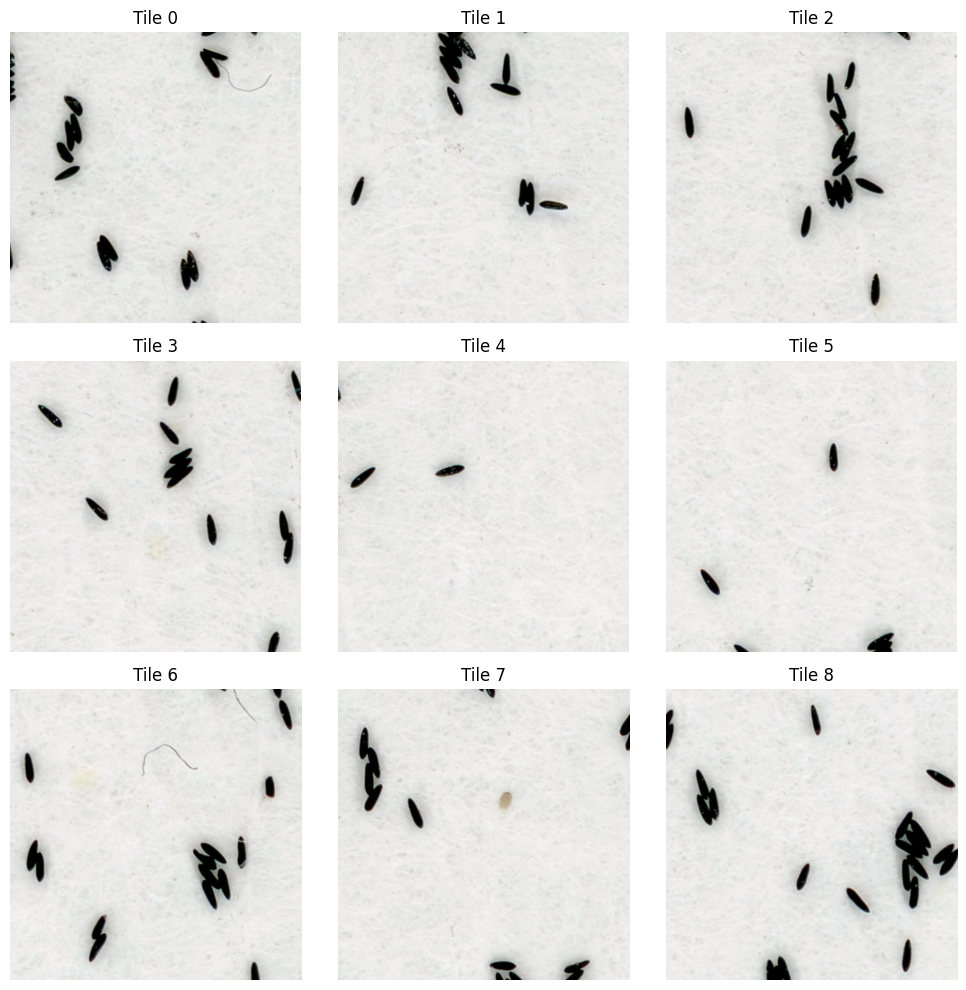

True

In [7]:
# Display the first 9 tiles
plt.figure(figsize=(10, 10))
for i in range(9):
    tile_rgb = cv2.cvtColor(tiles[i+150], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(tile_rgb)
    plt.title(f"Tile {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()
cv2.imwrite("out.jpg",tiles[150])

In [8]:
def merge_tiles_resized(tiles, new_width, new_height, dimSize):
    # Get the number of rows and columns of the image
    tiles_per_row = new_width // dimSize
    tiles_per_col = new_height // dimSize 

    rows = []
    for i in range(tiles_per_col):
        row_tiles = tiles[i * tiles_per_row : (i + 1) * tiles_per_row]
        if len(row_tiles) != tiles_per_row:
            print(f"Skipping incomplete row {i}")
            continue
        row = np.hstack(row_tiles)
        rows.append(row)

    if not rows:
        raise ValueError("No rows to merge.")

    merged_img = np.vstack(rows)
    return merged_img

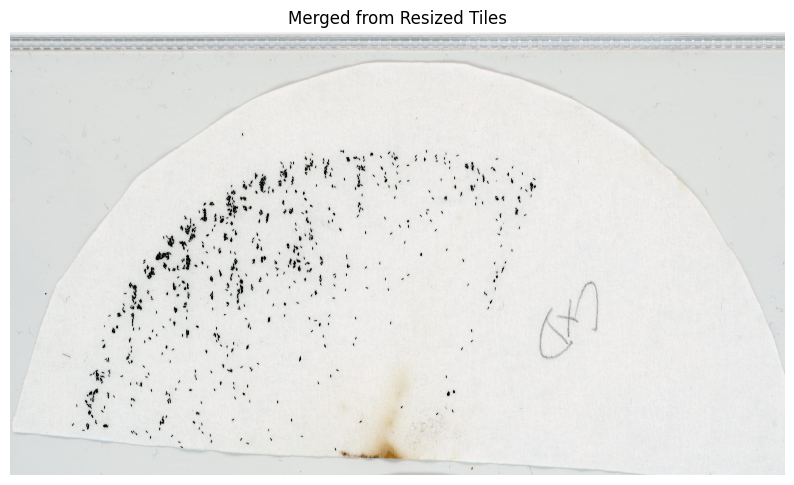

8192
14336


In [9]:
# Yes the image is bigger compared to the input.
merged = merge_tiles_resized(tiles, new_width, new_height, dimSize=512)



# Display using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(merged, cv2.COLOR_BGR2RGB))
plt.title("Merged from Resized Tiles")
plt.axis("off")
plt.show()

height, width = merged.shape[:2]
print(height)
print(width)


In [10]:
transforms = Compose([
    Resize((256, 256)),     # Optional: if tile is already 224x224, you can skip this
    ToTensor(),             # Converts to [C, H, W] and [0,1]
])

In [11]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cu126
12.6
True


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet()
model.load_state_dict(torch.load(model_dir, map_location=torch.device(device)))
model = model.to(device)
# convert to onnx

In [13]:
input = []
for tile in tiles:
    tile_pil = Image.fromarray(tile)
    input.append(transforms(tile_pil).unsqueeze(0).to(device))

In [14]:
print(len(input))

448


In [15]:
start_time = int(round(time.time() * 1000))
model.eval()
with torch.no_grad():
    # If input is a list of [1, 3, H, W] tensors, stack them into a batch
    batch = torch.cat(input, dim=0)  # or use torch.stack if each img is [3, H, W]

    outputs = model(batch)

print(f'Total time taken: {int(round(time.time() * 1000)) - start_time} ms')

Total time taken: 34335 ms


In [26]:
import numpy as np
from scipy.ndimage import maximum_filter

total_eggs = 0
peak_locations = []
for output in outputs:
    heatmap = output[0].cpu().detach().numpy()
    filtered = maximum_filter(heatmap, size=3)
    peaks = (heatmap == filtered) & (heatmap > 1)
    peak_locations.append(peaks)
    total_eggs += np.sum(peaks)


In [27]:
print(total_eggs)

1288


In [33]:
peaks_upscaled = cv2.resize(peaks.astype(np.uint8), (tile.shape[1], tile.shape[0]), interpolation=cv2.INTER_NEAREST)

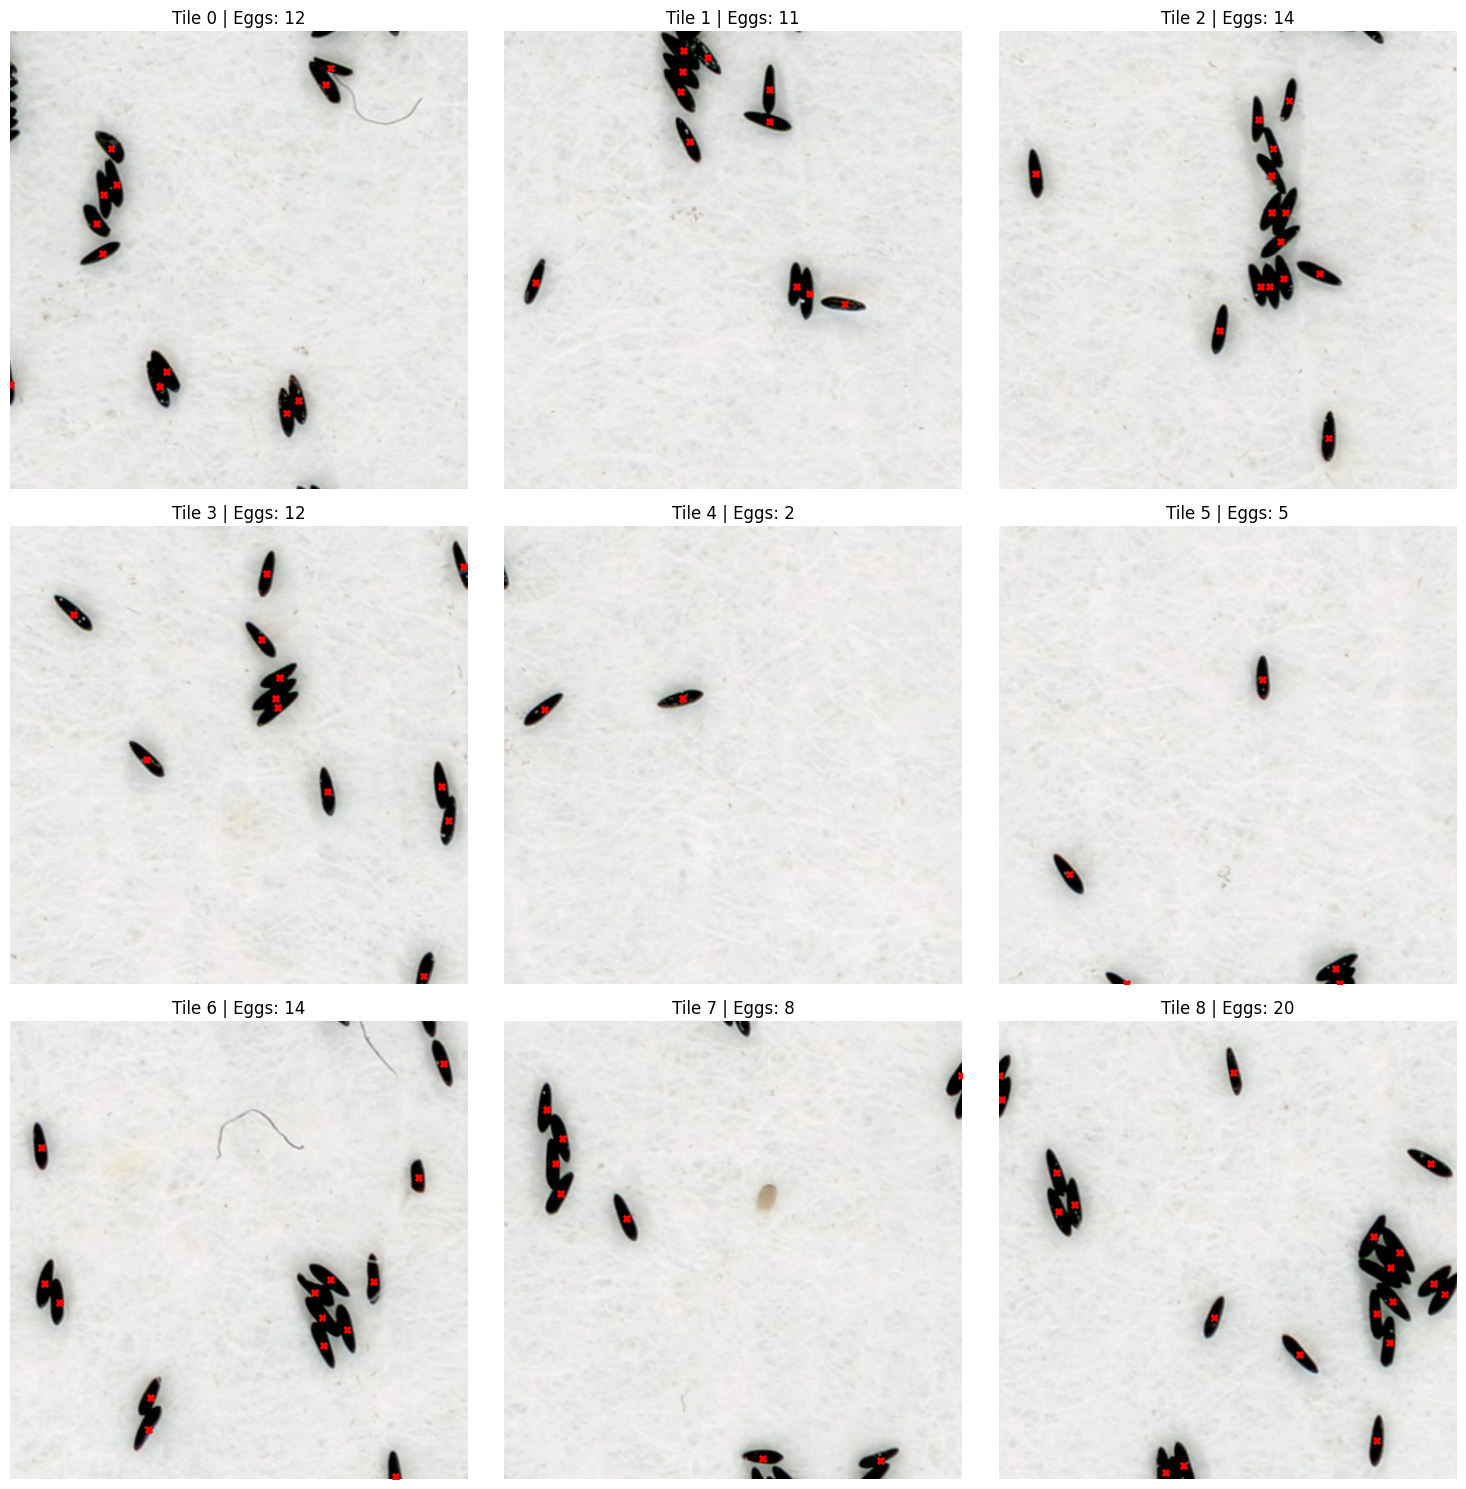

In [32]:
# Show first N tiles
N = 9
plt.figure(figsize=(15, 15))

for i in range(N):
    tile = tiles[i+150]  # original size: 512×512
    peaks = peak_locations[i+150]  # size: 256×256

    # Resize peak mask to match tile size (512x512)
    peaks_upscaled = cv2.resize(peaks.astype(np.uint8), (tile.shape[1], tile.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert tile to RGB for plotting
    tile_rgb = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

    # Plot the tile
    plt.subplot(3, 3, i + 1)
    plt.imshow(tile_rgb)
    plt.title(f"Tile {i} | Eggs: {np.sum(peaks)}")
    plt.axis('off')

    # Plot the peaks (now at original scale)
    y_coords, x_coords = np.where(peaks_upscaled)
    plt.scatter(x_coords, y_coords, s=15, c='red', marker='x')

plt.tight_layout()
plt.show()

In [49]:
def draw_peaks_on_merged_image(merged_img, peak_locations, dimSize, tiles_per_row):
    """
    Draws all peak circles on the merged image using global coordinates.
    
    - merged_img: the stitched image (from np.vstack/hstack)
    - peak_locations: list of binary masks (one per tile)
    - dimSize: tile size (e.g., 512)
    - tiles_per_row: how many tiles per row
    """
    for idx, peaks in enumerate(peak_locations):
        # Row and column position of the tile in the grid
        row = idx // tiles_per_row
        col = idx % tiles_per_row

        # Resize peak mask to match tile size
        peaks_resized = cv2.resize(peaks.astype(np.uint8), (dimSize, dimSize), interpolation=cv2.INTER_NEAREST)

        # Local (x, y) coordinates of peaks in the tile
        y_coords, x_coords = np.where(peaks_resized)

        for x, y in zip(x_coords, y_coords):
            # Global position on stitched image
            global_x = col * dimSize + x
            global_y = row * dimSize + y

            # Draw red dot
            cv2.circle(merged_img, (global_x, global_y), radius=5, color=(0, 0, 255), thickness=-1)

    return merged_img

In [50]:
stitched_img = merge_tiles_resized(tiles, new_width, new_height, dimSize=512)
tiles_per_row = new_width // 512

# Now draw peaks globally on the merged image
final_img = draw_peaks_on_merged_image(stitched_img, peak_locations, dimSize=512, tiles_per_row=tiles_per_row)

cv2.imwrite("stitched_with_global_peaks.jpg", final_img)

True